In [ ]:
!unzip '/content/twitter-training-data.txt.zip'

Archive:  /content/twitter-training-data.txt.zip
  inflating: twitter-training-data.txt  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from transformers import TFAutoModel, AutoTokenizer

In [ ]:
# Load dataset
df = pd.read_csv('/content/twitter-training-data.txt', sep='\t')

In [ ]:
df

,335104872099066692,positive,Felt privileged to play Foo Fighters songs on guitar today with one of the plectrums from the gig on Saturday.
0,796528524030124618,positive,@AaqibAfzaal Pakistan may be an Islamic countr...
1,760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! ...
2,147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 2...
3,732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when ma...
4,724826707518822134,positive,"@Hypable all good, I'm excited about a 3rd sea..."
...,...,...,...
45020,660374218263817235,neutral,Sunday Cinema | Paul McCartney &amp; David Gil...
45021,739323365061217061,neutral,"14-Aug The day of independence, The day of S..."
45022,681369726697754114,positive,"9 September has arrived, which means Apple's n..."
45023,922217029064536808,positive,So I'll see you all tomorrow for some fun fill...


In [ ]:
df.shape

(45025, 3)

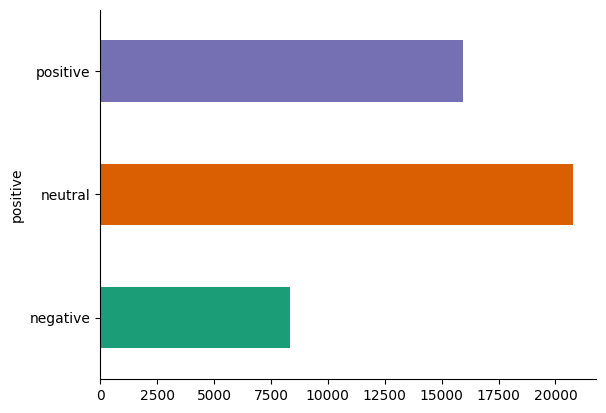

In [ ]:
df.groupby('positive').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-28-1e4a2eace666>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='335104872099066692', y='positive', inner='box', palette='Dark2')


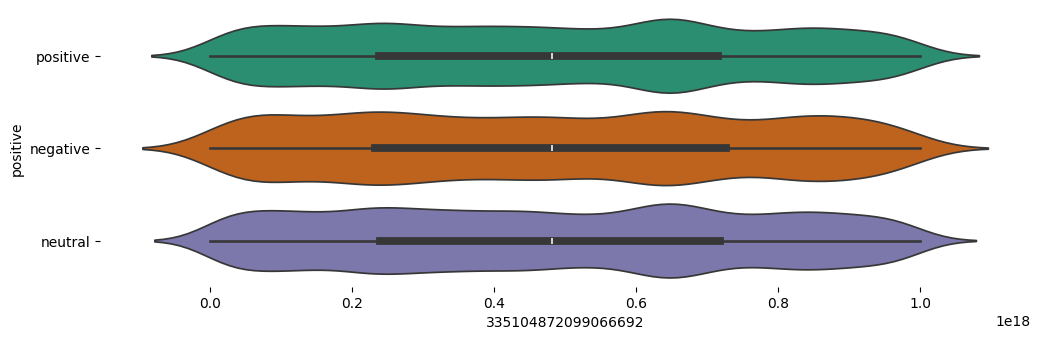

In [ ]:
figsize = (12, 1.2 * len(df['positive'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='335104872099066692', y='positive', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

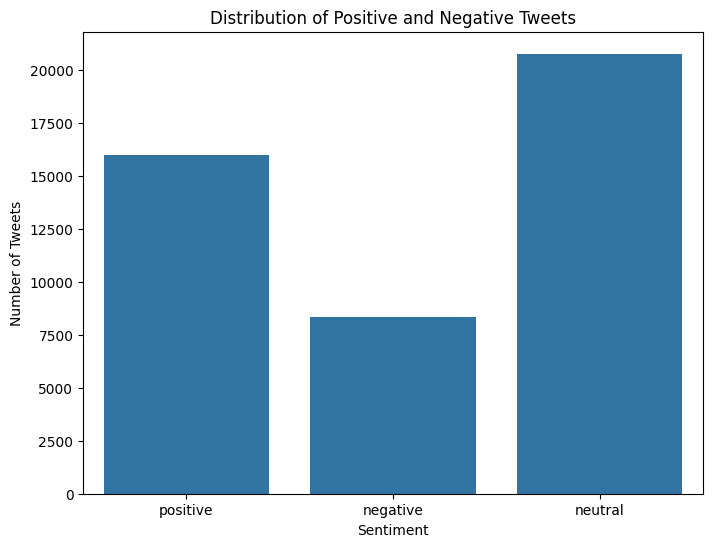

In [ ]:
# Countplot of 'positive' column
plt.figure(figsize=(8, 6))
sns.countplot(x='positive', data=df)
plt.title('Distribution of Positive and Negative Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

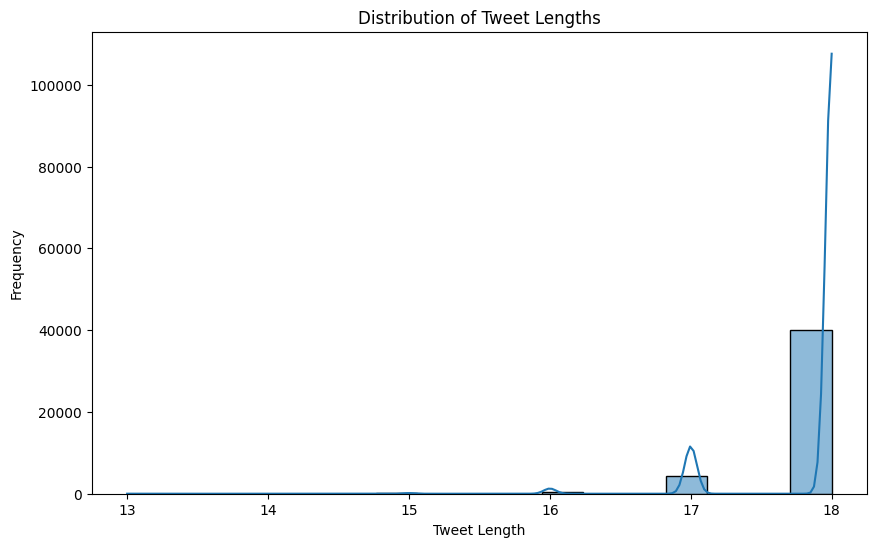

In [ ]:
# Distribution of tweet lengths
df['tweet_length'] = df['335104872099066692'].astype(str).apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

#Subtask A. (rerun): Message Polarity Classification: Given a message, classify whether the message is of positive, negative, or neutral sentiment.

In [ ]:
def load_data(file_path):
  data = []
  with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                tweet_id = parts[0]
                sentiment = parts[1]
                text = '\t'.join(parts[2:])
                data.append((tweet_id, sentiment, text))
  df = pd.DataFrame(data, columns=['tweet_id', 'sentiment', 'text'])
  return df

In [ ]:
file_path='/content/twitter-training-data.txt'

In [ ]:
df = load_data(file_path)
df.head()

,tweet_id,sentiment,text
0,335104872099066692,positive,Felt privileged to play Foo Fighters songs on ...
1,796528524030124618,positive,"""@AaqibAfzaal Pakistan may be an Islamic count..."
2,760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! ...
3,147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 2...
4,732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when ma...


In [ ]:
df.isna().sum()

,0
tweet_id,0
sentiment,0
text,0


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,20789
positive,15986
negative,8326


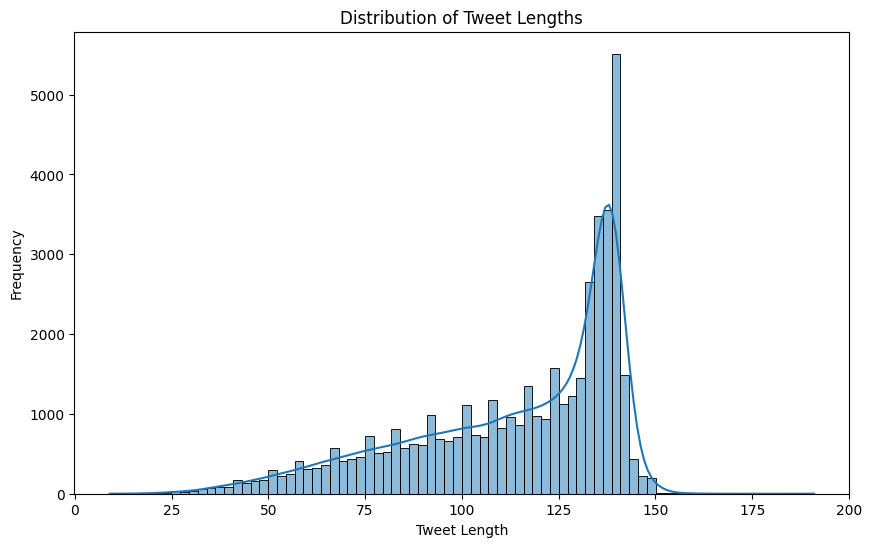

In [ ]:
df['tweet_length'] = df['text'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

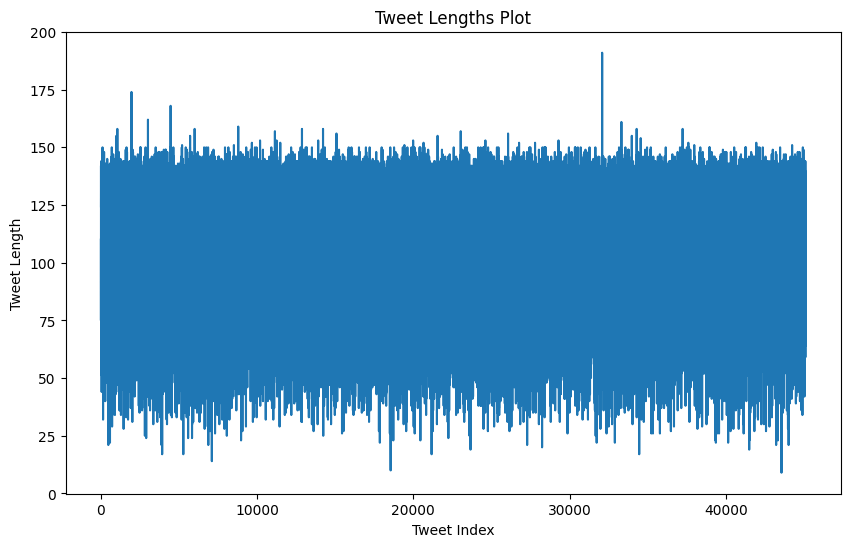

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['tweet_length'])
plt.title('Tweet Lengths Plot')
plt.xlabel('Tweet Index')
plt.ylabel('Tweet Length')
plt.show()

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = re.sub(r'@\w+', '', text)

  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  tokens = nltk.word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return ' '.join(tokens)

In [ ]:
df['processed_text'] = df['text'].apply(preprocess_text)

In [ ]:
df

,tweet_id,sentiment,text,tweet_length,processed_text
0,335104872099066692,positive,Felt privileged to play Foo Fighters songs on ...,110,felt privileged play foo fighter song guitar t...
1,796528524030124618,positive,"""@AaqibAfzaal Pakistan may be an Islamic count...",142,pakistan may islamic country der lot true musl...
2,760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! ...,139,happy birthday coolest golfer bali may become ...
3,147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 2...,75,tmills going tucson th thursday
4,732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when ma...,117,hmmmmm blacklivesmatter matter like rise kid d...
...,...,...,...,...,...
45096,660374218263817235,neutral,Sunday Cinema | Paul McCartney &amp; David Gil...,144,sunday cinema paul mccartney amp david gilmour...
45097,739323365061217061,neutral,"""14-Aug The day of independence, The day of ...",136,aug day independence day sacrifice muslim vict...
45098,681369726697754114,positive,"9 September has arrived, which means Apple's n...",134,september arrived mean apple new iphone hour a...
45099,922217029064536808,positive,So I'll see you all tomorrow for some fun fill...,108,ill see tomorrow fun filled feeding league pro...


In [ ]:
X = df['processed_text']
y = df['sentiment']

In [ ]:
X

,processed_text
0,felt privileged play foo fighter song guitar t...
1,pakistan may islamic country der lot true musl...
2,happy birthday coolest golfer bali may become ...
3,tmills going tucson th thursday
4,hmmmmm blacklivesmatter matter like rise kid d...
...,...
45096,sunday cinema paul mccartney amp david gilmour...
45097,aug day independence day sacrifice muslim vict...
45098,september arrived mean apple new iphone hour a...
45099,ill see tomorrow fun filled feeding league pro...


In [ ]:
y

,sentiment
0,positive
1,positive
2,positive
3,negative
4,negative
...,...
45096,neutral
45097,neutral
45098,positive
45099,positive


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train

,processed_text
8688,monday u open murray federer amp konta action ...
8188,robbie keane score goal tonight may like
31763,know leo u know big come party leo tomorrow ni...
14296,forbes cupertino ca october apple ceo tim cook...
30575,right time admit chose mozartinspired nokia ri...
...,...
6781,jo whiley name checked sunday brunch morning o...
35213,ready party u march fourth marching band mthds...
23754,sanctuary savior tee inspired thewalkingdead s...
853,foo fighter saturday sunday night asking please


In [ ]:
X_test

,processed_text
37817,like nintendo could come tomorrow saying kirby...
42323,hillary starting campaign rd time
6736,think wednesday day lay bed day watching netfl...
21887,gucci bag superego good hope january flaunt du...
12283,stop fracking cuadrilla persecuting land defen...
...,...
10459,oh god want bioshock infinite right february f...
21767,people worried david price pitching tomorrow s...
758,madonna th year earned million back really exp...
1607,oliseh meet victor moses london super eagle co...


In [ ]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45101,), (45101,), (36080,), (36080,), (9021,), (9021,))

In [ ]:
# Tokenization
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
# X_train is already a Series with the 'processed_text' values, so you don't need to specify the column name.
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [ ]:
X_test_seq

array([[   0,    0,    0, ...,  337, 8311,   20],
       [   0,    0,    0, ...,  796,   28,   13],
       [   0,    0,    0, ..., 1891,  152,  176],
       ...,
       [   0,    0,    0, ...,   40,   67, 3578],
       [   0,    0,    0, ..., 1088,  999,  531],
       [   0,    0,    0, ...,  984,  154,    4]], dtype=int32)

In [ ]:
X_train_seq

array([[   0,    0,    0, ...,    1, 8757,   29],
       [   0,    0,    0, ...,   33,    3,   12],
       [   0,    0,    0, ...,    7, 6031, 2749],
       ...,
       [   0,    0,    0, ...,    1, 1567,   36],
       [   0,    0,    0, ...,    7, 1419,  134],
       [   0,    0,    0, ..., 6465, 1922,    1]], dtype=int32)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Transform your target variables to numerical labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build LSTM model for multi-class classification
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
lstm_model.fit(X_train_seq, y_train_encoded, validation_data=(X_test_seq, y_test_encoded), epochs=30, batch_size=32)

Epoch 1/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 243s 215ms/step - accuracy: 0.5884 - loss: 0.8678 - val_accuracy: 0.6560 - val_loss: 0.7607
Epoch 2/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 242s 215ms/step - accuracy: 0.7231 - loss: 0.6378 - val_accuracy: 0.6489 - val_loss: 0.7844
Epoch 3/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 263s 216ms/step - accuracy: 0.7848 - loss: 0.5097 - val_accuracy: 0.6394 - val_loss: 0.8278
Epoch 4/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 244s 216ms/step - accuracy: 0.8340 - loss: 0.4059 - val_accuracy: 0.6238 - val_loss: 0.9951
Epoch 5/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 242s 215ms/step - accuracy: 0.8733 - loss: 0.3110 - val_accuracy: 0.6272 - val_loss: 1.1972
Epoch 6/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 262s 215ms/step - accuracy: 0.9027 - loss: 0.2429 - val_accuracy: 0.6080 - val_loss: 1.3311
Epoch 7/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 253s 208ms/step - accuracy: 0.9225 - loss: 0.1949 - val_accuracy: 0.6081 - val_loss: 1.5410
Epoch 8/30
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 270s 215ms/step - ac

282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step


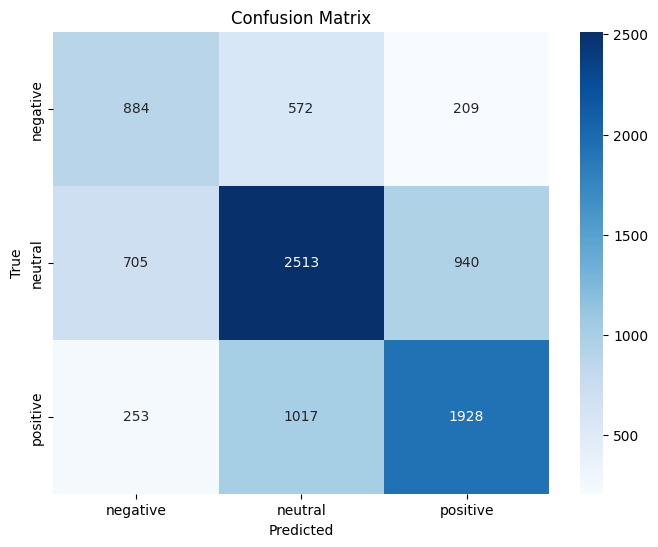

              precision    recall  f1-score   support

    negative       0.48      0.53      0.50      1665
     neutral       0.61      0.60      0.61      4158
    positive       0.63      0.60      0.61      3198

    accuracy                           0.59      9021
   macro avg       0.57      0.58      0.58      9021
weighted avg       0.59      0.59      0.59      9021



In [ ]:

import matplotlib.pyplot as plt
import numpy as np
y_pred_encoded = lstm_model.predict(X_test_seq)
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_encoded, axis=1))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from transformers import BertTokenizer, BertModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the dataset
df = pd.read_csv('/content/twitter-training-data.txt', sep='\t', header=None)
df.columns = ['id', 'sentiment', 'text']

# Clean the text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])


word_counts = Counter(" ".join(df['cleaned_text']).split())
topics = [word for word, count in word_counts.most_common(20) if count > 100 and len(word) > 3]

print(f"Identified topics: {topics}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Identified topics: ['tomorrow', 'going', 'night', 'like', 'time', 'sunday', 'friday', 'game']


In [ ]:
# Task A: 3-class sentiment classification (positive, negative, neutral)

# Create vocabulary and numericalize text
word_counts = Counter(" ".join(train_df['cleaned_text']).split())
vocab = {word: idx+2 for idx, word in enumerate(word_counts.keys())}  # 0 for padding, 1 for unknown
vocab_size = len(vocab) + 2  # +2 for padding and unknown

# Convert sentiment labels to numerical values
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
train_df['sentiment_num'] = train_df['sentiment'].map(sentiment_map)
test_df['sentiment_num'] = test_df['sentiment'].map(sentiment_map)

# Convert text to sequences of indices
def text_to_sequence(text, vocab, max_len=50):
    sequence = [vocab.get(word, 1) for word in text.split()[:max_len]]
    if len(sequence) < max_len:
        sequence += [0] * (max_len - len(sequence))  # pad with zeros
    return sequence[:max_len]

max_len = 50
train_sequences = [text_to_sequence(text, vocab, max_len) for text in train_df['cleaned_text']]
test_sequences = [text_to_sequence(text, vocab, max_len) for text in test_df['cleaned_text']]

# Convert to PyTorch tensors
X_train = torch.LongTensor(train_sequences)
y_train = torch.LongTensor(train_df['sentiment_num'].values)
X_test = torch.LongTensor(test_sequences)
y_test = torch.LongTensor(test_df['sentiment_num'].values)

# Create a custom Dataset
class TwitterDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TwitterDataset(X_train, y_train)
test_dataset = TwitterDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(lstm_out[:, -1, :])
        output = self.fc(hidden)
        return output

# Hyperparameters
embedding_dim = 100
hidden_dim = 256
output_dim = 3  # positive, negative, neutral
n_layers = 2
dropout = 0.5

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training function
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text)
        loss = criterion(predictions, labels)

        acc = (predictions.argmax(1) == labels).float().mean()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)

            acc = (predictions.argmax(1) == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Train the model
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'task_a_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Load the best model
model.load_state_dict(torch.load('task_a_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Generate predictions
def predict_sentiment(model, sentence, vocab, max_len=50):
    model.eval()
    tokenized = text_to_sequence(clean_text(sentence), vocab, max_len)
    tensor = torch.LongTensor(tokenized).unsqueeze(0).to(device)
    prediction = model(tensor).argmax(1)
    return ['positive', 'negative', 'neutral'][prediction.item()]

# Example prediction
sample_text = "I love this product! It's amazing."
print(f"Predicted sentiment: {predict_sentiment(model, sample_text, vocab)}")

Epoch: 01
	Train Loss: 1.041 | Train Acc: 45.93%
	 Val. Loss: 1.040 |  Val. Acc: 46.10%
Epoch: 02
	Train Loss: 1.039 | Train Acc: 46.08%
	 Val. Loss: 1.038 |  Val. Acc: 46.10%
Epoch: 03
	Train Loss: 1.039 | Train Acc: 46.08%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 04
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 05
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.038 |  Val. Acc: 46.10%
Epoch: 06
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 07
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 08
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 09
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 10
	Train Loss: 1.037 | Train Acc: 46.08%
	 Val. Loss: 1.038 |  Val. Acc: 46.10%
Epoch: 11
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 12
	Train Loss: 1.037 | T

Epoch: 01
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 02
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 03
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 04
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 05
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 06
	Train Loss: 1.037 | Train Acc: 46.10%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 07
	Train Loss: 1.037 | Train Acc: 46.10%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 08
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 09
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.09%
Epoch: 10
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 11
	Train Loss: 1.037 | Train Acc: 46.10%
	 Val. Loss: 1.037 |  Val. Acc: 46.09%
Epoch: 12
	Train Loss: 1.037 | T

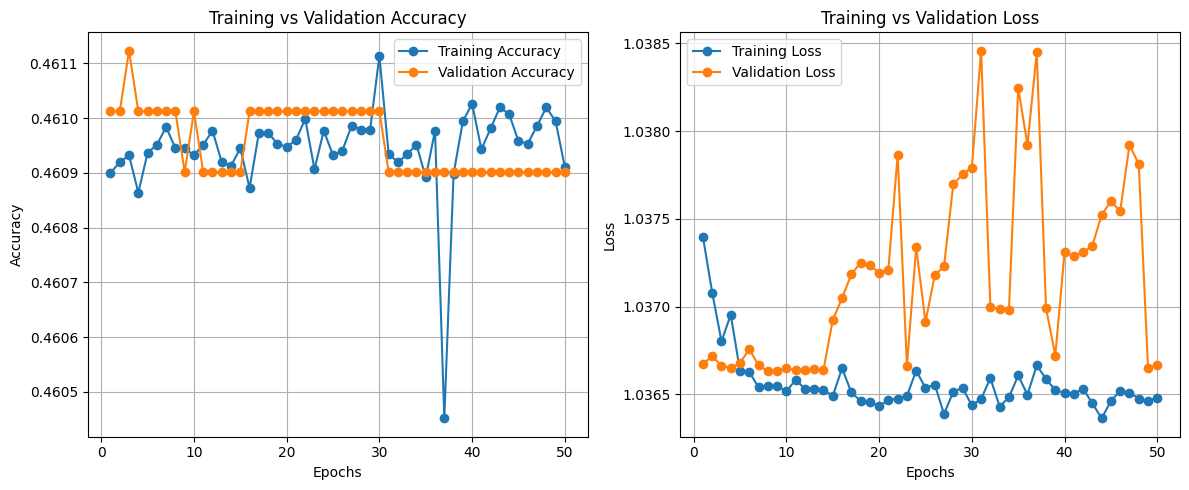

In [ ]:
import matplotlib.pyplot as plt

# Modify your training loop to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'task_a_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_accs, label='Training Accuracy', marker='o')
plt.plot(range(1, n_epochs+1), val_accs, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

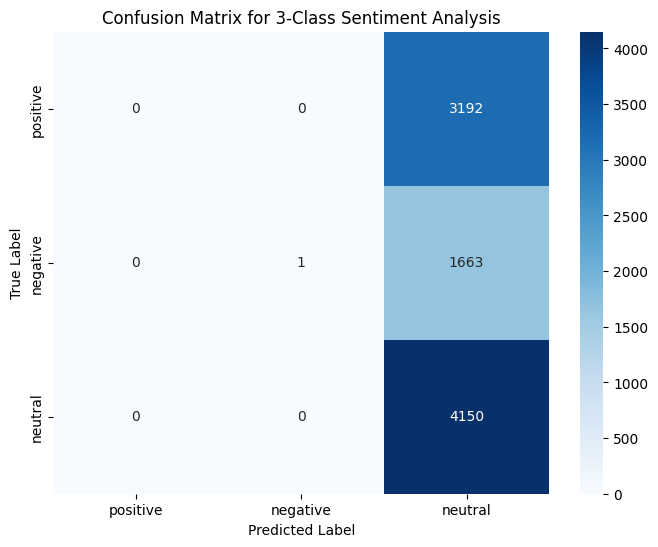


Classification Report:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00      3192
    negative       1.00      0.00      0.00      1664
     neutral       0.46      1.00      0.63      4150

    accuracy                           0.46      9006
   macro avg       0.49      0.33      0.21      9006
weighted avg       0.40      0.46      0.29      9006



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to get predictions and true labels
def get_predictions(model, iterator):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            preds = predictions.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get predictions on test set
true_labels, pred_labels = get_predictions(model, test_loader)

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
class_names = ['positive', 'negative', 'neutral']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 3-Class Sentiment Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

In [ ]:
!unzip '/content/twitter-training-data.txt.zip'

Archive:  /content/twitter-training-data.txt.zip
  inflating: twitter-training-data.txt  


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from transformers import BertTokenizer, BertModel

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the dataset
df = pd.read_csv('/content/twitter-training-data.txt', sep='\t', header=None)
df.columns = ['id', 'sentiment', 'text']

# Clean the text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()

    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

word_counts = Counter(" ".join(df['cleaned_text']).split())

topics = [word for word, count in word_counts.most_common(20) if count > 100 and len(word) > 3]

print(f"Identified topics: {topics}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Identified topics: ['tomorrow', 'going', 'night', 'like', 'time', 'sunday', 'friday', 'game']


In [ ]:
# Task A: 3-class sentiment classification (positive, negative, neutral)

# Create vocabulary and numericalize text
word_counts = Counter(" ".join(train_df['cleaned_text']).split())
vocab = {word: idx+2 for idx, word in enumerate(word_counts.keys())}  # 0 for padding, 1 for unknown
vocab_size = len(vocab) + 2  # +2 for padding and unknown

# Convert sentiment labels to numerical values
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
train_df['sentiment_num'] = train_df['sentiment'].map(sentiment_map)
test_df['sentiment_num'] = test_df['sentiment'].map(sentiment_map)

# Convert text to sequences of indices
def text_to_sequence(text, vocab, max_len=50):
    sequence = [vocab.get(word, 1) for word in text.split()[:max_len]]
    if len(sequence) < max_len:
        sequence += [0] * (max_len - len(sequence))  # pad with zeros
    return sequence[:max_len]

max_len = 50
train_sequences = [text_to_sequence(text, vocab, max_len) for text in train_df['cleaned_text']]
test_sequences = [text_to_sequence(text, vocab, max_len) for text in test_df['cleaned_text']]

# Convert to PyTorch tensors
X_train = torch.LongTensor(train_sequences)
y_train = torch.LongTensor(train_df['sentiment_num'].values)
X_test = torch.LongTensor(test_sequences)
y_test = torch.LongTensor(test_df['sentiment_num'].values)

# Create a custom Dataset
class TwitterDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TwitterDataset(X_train, y_train)
test_dataset = TwitterDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(lstm_out[:, -1, :])
        output = self.fc(hidden)
        return output

# Hyperparameters
embedding_dim = 100
hidden_dim = 256
output_dim = 3  # positive, negative, neutral
n_layers = 2
dropout = 0.5

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training function
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text)
        loss = criterion(predictions, labels)

        acc = (predictions.argmax(1) == labels).float().mean()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)

            acc = (predictions.argmax(1) == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Train the model
n_epochs = 10
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'task_a_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Load the best model
model.load_state_dict(torch.load('task_a_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Generate predictions
def predict_sentiment(model, sentence, vocab, max_len=50):
    model.eval()
    tokenized = text_to_sequence(clean_text(sentence), vocab, max_len)
    tensor = torch.LongTensor(tokenized).unsqueeze(0).to(device)
    prediction = model(tensor).argmax(1)
    return ['positive', 'negative', 'neutral'][prediction.item()]

# Example prediction
sample_text = "I love this product! It's amazing."
print(f"Predicted sentiment: {predict_sentiment(model, sample_text, vocab)}")

Epoch: 01
	Train Loss: 1.041 | Train Acc: 45.93%
	 Val. Loss: 1.040 |  Val. Acc: 46.10%
Epoch: 02
	Train Loss: 1.039 | Train Acc: 46.08%
	 Val. Loss: 1.038 |  Val. Acc: 46.10%
Epoch: 03
	Train Loss: 1.039 | Train Acc: 46.08%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 04
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 05
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.038 |  Val. Acc: 46.10%
Epoch: 06
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 07
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 08
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.10%
Epoch: 09
	Train Loss: 1.038 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 10
	Train Loss: 1.037 | Train Acc: 46.08%
	 Val. Loss: 1.038 |  Val. Acc: 46.10%
Test Loss: 1.037 | Test Acc: 46.11%
Predicted sentiment: neutral


Epoch: 01
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 02
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 03
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 04
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 05
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 06
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 07
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 08
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 09
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%
Epoch: 10
	Train Loss: 1.037 | Train Acc: 46.09%
	 Val. Loss: 1.037 |  Val. Acc: 46.11%


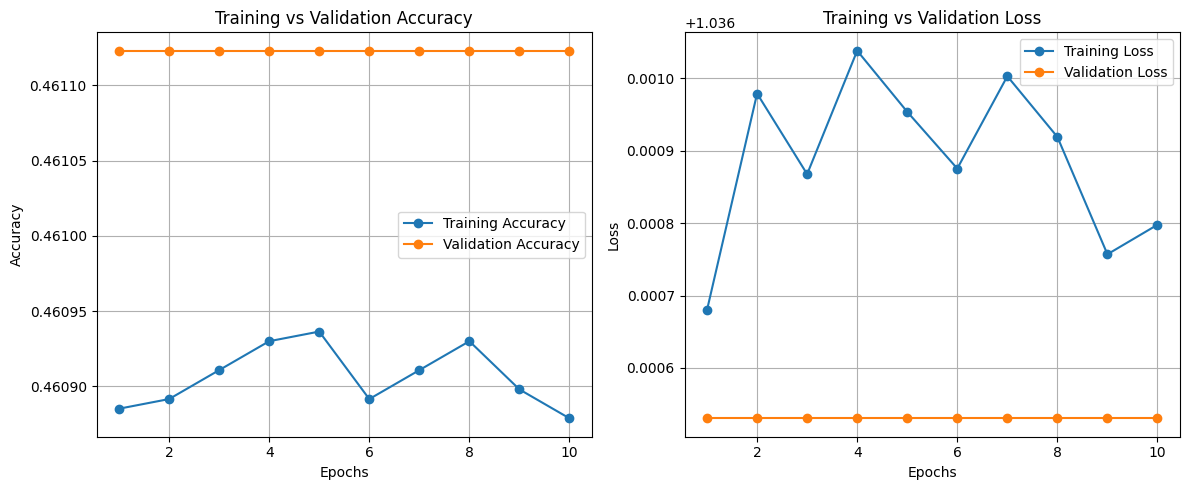

In [ ]:
import matplotlib.pyplot as plt

# Modify your training loop to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

n_epochs = 10
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)

    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'task_a_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_accs, label='Training Accuracy', marker='o')
plt.plot(range(1, n_epochs+1), val_accs, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

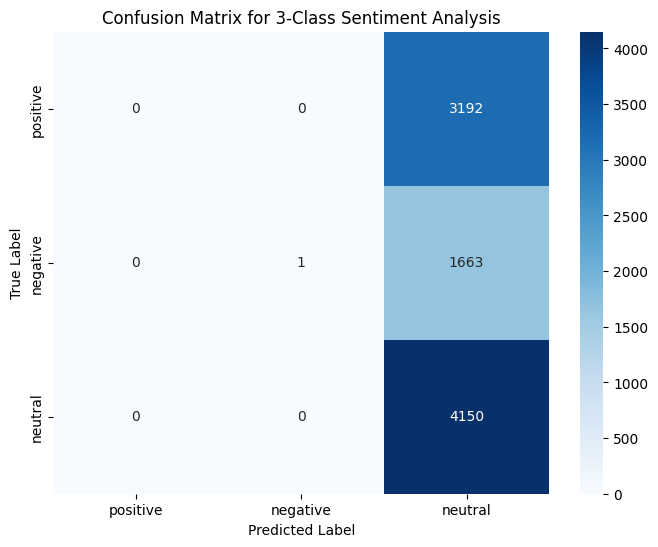


Classification Report:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00      3192
    negative       1.00      0.00      0.00      1664
     neutral       0.46      1.00      0.63      4150

    accuracy                           0.46      9006
   macro avg       0.49      0.33      0.21      9006
weighted avg       0.40      0.46      0.29      9006



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to get predictions and true labels
def get_predictions(model, iterator):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            preds = predictions.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get predictions on test set
true_labels, pred_labels = get_predictions(model, test_loader)

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
class_names = ['positive', 'negative', 'neutral']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 3-Class Sentiment Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

In [ ]:
topic = topics[0]
print(f"Analyzing sentiment for topic: {topic}")

# Filter tweets that mention the topic
topic_train_df = train_df[train_df['cleaned_text'].str.contains(topic)]
topic_test_df = test_df[test_df['cleaned_text'].str.contains(topic)]

# Only keep positive and negative (remove neutral for 2-class)
topic_train_df = topic_train_df[topic_train_df['sentiment'].isin(['positive', 'negative'])]
topic_test_df = topic_test_df[topic_test_df['sentiment'].isin(['positive', 'negative'])]

# Convert sentiment labels to binary
sentiment_map_binary = {'positive': 0, 'negative': 1}
topic_train_df['sentiment_num'] = topic_train_df['sentiment'].map(sentiment_map_binary)
topic_test_df['sentiment_num'] = topic_test_df['sentiment'].map(sentiment_map_binary)

# Prepare data
topic_train_sequences = [text_to_sequence(text, vocab, max_len) for text in topic_train_df['cleaned_text']]
topic_test_sequences = [text_to_sequence(text, vocab, max_len) for text in topic_test_df['cleaned_text']]

X_train_topic = torch.LongTensor(topic_train_sequences)
y_train_topic = torch.LongTensor(topic_train_df['sentiment_num'].values)
X_test_topic = torch.LongTensor(topic_test_sequences)
y_test_topic = torch.LongTensor(topic_test_df['sentiment_num'].values)

# Create datasets and dataloaders
topic_train_dataset = TwitterDataset(X_train_topic, y_train_topic)
topic_test_dataset = TwitterDataset(X_test_topic, y_test_topic)

topic_train_loader = DataLoader(topic_train_dataset, batch_size=batch_size, shuffle=True)
topic_test_loader = DataLoader(topic_test_dataset, batch_size=batch_size)

# Define a similar model but with binary output
class TopicSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(lstm_out[:, -1, :])
        output = self.fc(hidden)
        return output

# Binary classification
output_dim = 2
topic_model = TopicSentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
topic_model = topic_model.to(device)
optimizer = torch.optim.Adam(topic_model.parameters())

# Train the topic-specific model
for epoch in range(10):
    train_loss, train_acc = train(topic_model, topic_train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(topic_model, topic_test_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(topic_model.state_dict(), 'task_b_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Load the best model
topic_model.load_state_dict(torch.load('task_b_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(topic_model, topic_test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Prediction function for topic sentiment
def predict_topic_sentiment(model, sentence, vocab, max_len=50):
    model.eval()
    tokenized = text_to_sequence(clean_text(sentence), vocab, max_len)
    tensor = torch.LongTensor(tokenized).unsqueeze(0).to(device)
    prediction = model(tensor).argmax(1)
    return ['positive', 'negative'][prediction.item()]

# Example prediction
sample_text = f"This {topic} is terrible!"
print(f"Predicted sentiment for topic '{topic}': {predict_topic_sentiment(topic_model, sample_text, vocab)}")

Analyzing sentiment for topic: tomorrow
Epoch: 01
	Train Loss: 0.519 | Train Acc: 78.42%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Epoch: 02
	Train Loss: 0.506 | Train Acc: 79.95%
	 Val. Loss: 0.510 |  Val. Acc: 80.13%
Epoch: 03
	Train Loss: 0.506 | Train Acc: 79.94%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Epoch: 04
	Train Loss: 0.504 | Train Acc: 79.96%
	 Val. Loss: 0.505 |  Val. Acc: 80.13%
Epoch: 05
	Train Loss: 0.510 | Train Acc: 79.99%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Epoch: 06
	Train Loss: 0.504 | Train Acc: 79.95%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Epoch: 07
	Train Loss: 0.507 | Train Acc: 80.08%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Epoch: 08
	Train Loss: 0.504 | Train Acc: 80.01%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Epoch: 09
	Train Loss: 0.505 | Train Acc: 80.01%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Epoch: 10
	Train Loss: 0.503 | Train Acc: 80.08%
	 Val. Loss: 0.499 |  Val. Acc: 80.13%
Test Loss: 0.499 | Test Acc: 80.13%
Predicted sentiment for topic 'tomorrow': po

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
class_names = ['positive', 'negative']

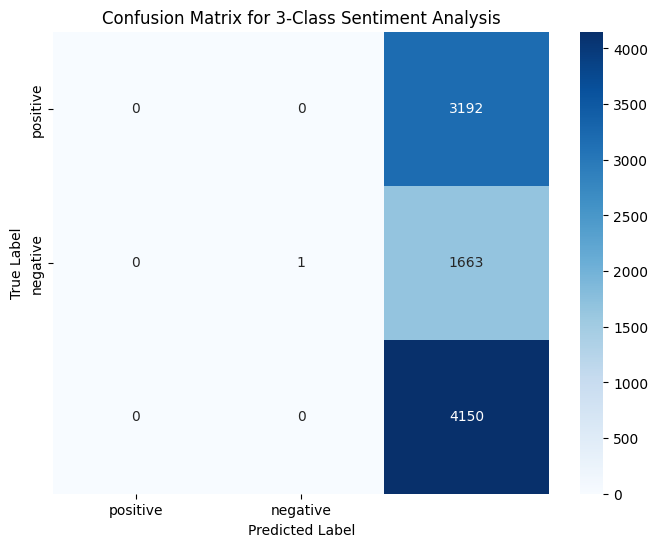

In [ ]:
import matplotlib.pyplot as plt
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 2-Class Sentiment Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

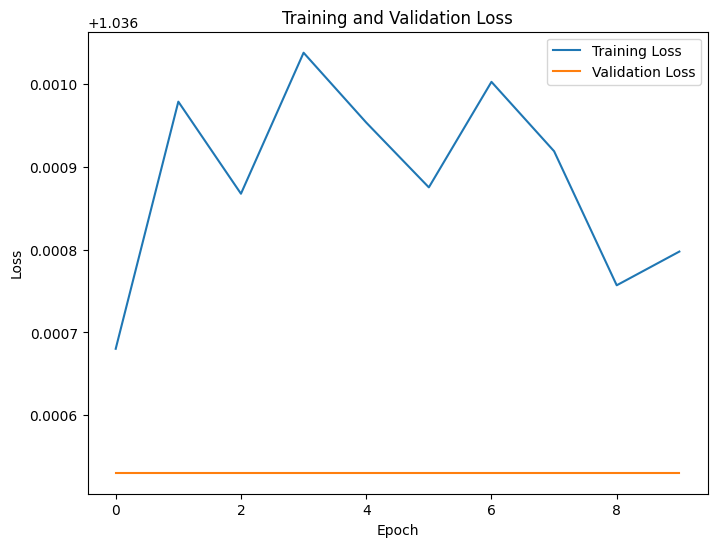

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Task C: Topic-based sentiment classification (3-class: positive/negative/neutral)

In [ ]:
topic_train_df = train_df[train_df['cleaned_text'].str.contains(topic)]
topic_test_df = test_df[test_df['cleaned_text'].str.contains(topic)]


In [ ]:
# Convert sentiment labels to numerical values (3-class)
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
topic_train_df['sentiment_num'] = topic_train_df['sentiment'].map(sentiment_map)
topic_test_df['sentiment_num'] = topic_test_df['sentiment'].map(sentiment_map)

<ipython-input-16-19efca1012e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_train_df['sentiment_num'] = topic_train_df['sentiment'].map(sentiment_map)
<ipython-input-16-19efca1012e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_test_df['sentiment_num'] = topic_test_df['sentiment'].map(sentiment_map)


In [ ]:
topic_train_df

,id,sentiment,text,cleaned_text,sentiment_num
41501,928262712209155289,positive,"Paul Dunne is going to be so nervous tomorrow,...",paul dunne going nervous tomorrow awesome he p...,0
40015,671865103697350617,neutral,Because of you @NFL I'm going to have to watch...,nfl im going watch big brother tomorrow,2
19677,643397778194024681,negative,Chinese websites are blocking search results f...,chinese website blocking search result fatty k...,1
31975,227556912364307164,positive,Been listening to Dom all day and then he drop...,listening dom day drop surprise mixtape ill li...,0
40656,372332743569629113,positive,Monroe bound tomorrow! It's a must leave Rusto...,monroe bound tomorrow must leave ruston day,0
...,...,...,...,...,...
21978,522843065783761854,neutral,I will make Julian Stark flex for every person...,make julian stark flex every person sign matt ...,2
33915,244659451661638218,positive,can't wait for the West Chester Ohio Rally wit...,cant wait west chester ohio rally mitt tomorro...,0
11808,26869051666569655,negative,Gonna watch the rest of X Factor tomorrow caus...,gonna watch rest x factor tomorrow cause im ti...,1
43320,697170196840221231,positive,possibly going to digi tomorrow with nib and m...,possibly going digi tomorrow nib macky,0


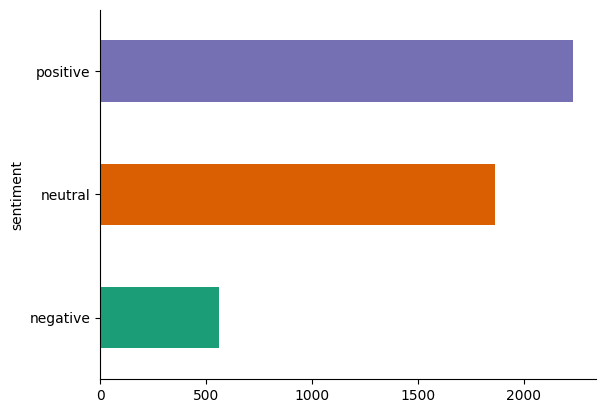

In [ ]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
topic_train_df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:

# Prepare data
topic_train_sequences = [text_to_sequence(text, vocab, max_len) for text in topic_train_df['cleaned_text']]
topic_test_sequences = [text_to_sequence(text, vocab, max_len) for text in topic_test_df['cleaned_text']]

In [ ]:
len(topic_train_sequences), len(topic_test_sequences)

(4659, 1142)

In [ ]:
X_train_topic = torch.LongTensor(topic_train_sequences)
y_train_topic = torch.LongTensor(topic_train_df['sentiment_num'].values)
X_test_topic = torch.LongTensor(topic_test_sequences)
y_test_topic = torch.LongTensor(topic_test_df['sentiment_num'].values)


In [ ]:
X_train_topic.shape, y_train_topic.shape, X_test_topic.shape, y_test_topic.shape

(torch.Size([4659, 50]),
 torch.Size([4659]),
 torch.Size([1142, 50]),
 torch.Size([1142]))

In [ ]:
# Create datasets and dataloaders
topic_train_dataset = TwitterDataset(X_train_topic, y_train_topic)
topic_test_dataset = TwitterDataset(X_test_topic, y_test_topic)

In [ ]:
# Create datasets and dataloaders
topic_train_dataset = TwitterDataset(X_train_topic, y_train_topic)
topic_test_dataset = TwitterDataset(X_test_topic, y_test_topic)

topic_train_loader = DataLoader(topic_train_dataset, batch_size=batch_size, shuffle=True)
topic_test_loader = DataLoader(topic_test_dataset, batch_size=batch_size)

In [ ]:
# Use the same model architecture as Task A (3-class output)
output_dim = 3
topic_model_3class = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
topic_model_3class = topic_model_3class.to(device)
optimizer = torch.optim.Adam(topic_model_3class.parameters())


In [ ]:
best_valid_loss = float('inf')  # Initialize with a large value

# Train the topic-specific 3-class model
for epoch in range(20):
    train_loss, train_acc = train(topic_model_3class, topic_train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(topic_model_3class, topic_test_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(topic_model_3class.state_dict(), 'task_c_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.976 | Train Acc: 47.63%
	 Val. Loss: 0.970 |  Val. Acc: 48.30%
Epoch: 02
	Train Loss: 0.975 | Train Acc: 47.98%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 03
	Train Loss: 0.976 | Train Acc: 47.94%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 04
	Train Loss: 0.975 | Train Acc: 47.86%
	 Val. Loss: 0.970 |  Val. Acc: 48.22%
Epoch: 05
	Train Loss: 0.975 | Train Acc: 47.90%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 06
	Train Loss: 0.975 | Train Acc: 47.80%
	 Val. Loss: 0.972 |  Val. Acc: 48.22%
Epoch: 07
	Train Loss: 0.975 | Train Acc: 47.42%
	 Val. Loss: 0.972 |  Val. Acc: 48.22%
Epoch: 08
	Train Loss: 0.975 | Train Acc: 47.97%
	 Val. Loss: 0.970 |  Val. Acc: 48.22%
Epoch: 09
	Train Loss: 0.975 | Train Acc: 47.96%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 10
	Train Loss: 0.977 | Train Acc: 47.90%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 11
	Train Loss: 0.975 | Train Acc: 47.79%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 12
	Train Loss: 0.974 | T

In [ ]:
# Load the best model if it exists
import os
if os.path.exists('task_c_model.pt'):
    topic_model_3class.load_state_dict(torch.load('task_c_model.pt'))
else:
    print("No saved model found, using final trained model")

In [ ]:
topic_model_3class.load_state_dict(torch.load('task_c_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(topic_model_3class, topic_test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Prediction function for 3-class topic sentiment
def predict_topic_sentiment_3class(model, sentence, vocab, max_len=50):
    model.eval()
    tokenized = text_to_sequence(clean_text(sentence), vocab, max_len)
    tensor = torch.LongTensor(tokenized).unsqueeze(0).to(device)
    prediction = model(tensor).argmax(1)
    return ['positive', 'negative', 'neutral'][prediction.item()]

# Example prediction
sample_text = f"This {topic} is okay, I guess."
print(f"Predicted sentiment for topic '{topic}': {predict_topic_sentiment_3class(topic_model_3class, sample_text, vocab)}")

Test Loss: 0.970 | Test Acc: 48.22%
Predicted sentiment for topic 'tomorrow': positive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Initialize variables to track loss and accuracy
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

best_valid_loss = float('inf')

# Training loop
for epoch in range(n_epochs):
    train_loss, train_acc = train(topic_model_3class, topic_train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(topic_model_3class, topic_test_loader, criterion)

    # Store losses and accuracies
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(topic_model_3class.state_dict(), 'task_c_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.974 | Train Acc: 47.78%
	 Val. Loss: 0.974 |  Val. Acc: 48.22%
Epoch: 02
	Train Loss: 0.974 | Train Acc: 48.11%
	 Val. Loss: 0.970 |  Val. Acc: 48.22%
Epoch: 03
	Train Loss: 0.974 | Train Acc: 48.06%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 04
	Train Loss: 0.975 | Train Acc: 47.90%
	 Val. Loss: 0.970 |  Val. Acc: 48.22%
Epoch: 05
	Train Loss: 0.974 | Train Acc: 47.68%
	 Val. Loss: 0.972 |  Val. Acc: 48.22%
Epoch: 06
	Train Loss: 0.975 | Train Acc: 48.13%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 07
	Train Loss: 0.975 | Train Acc: 48.00%
	 Val. Loss: 0.972 |  Val. Acc: 48.22%
Epoch: 08
	Train Loss: 0.976 | Train Acc: 47.46%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 09
	Train Loss: 0.973 | Train Acc: 47.93%
	 Val. Loss: 0.971 |  Val. Acc: 48.22%
Epoch: 10
	Train Loss: 0.975 | Train Acc: 47.87%
	 Val. Loss: 0.972 |  Val. Acc: 48.22%


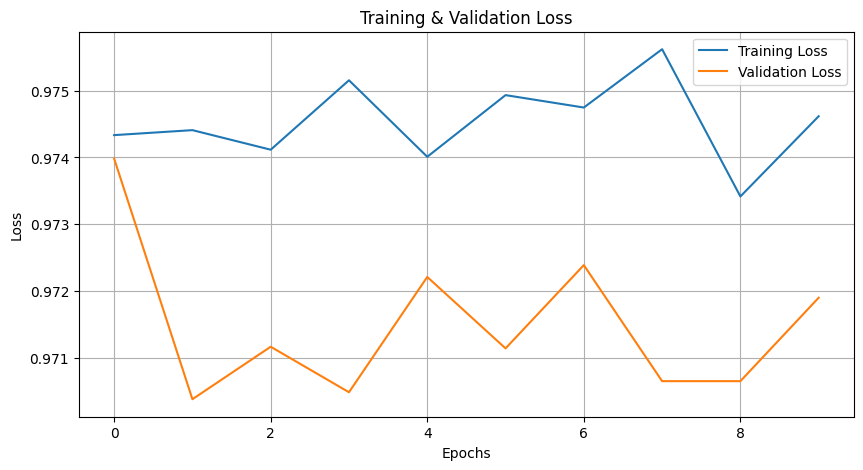

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

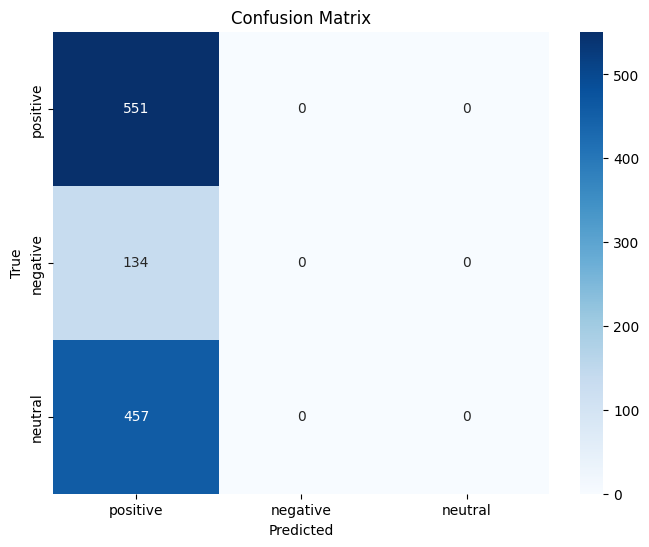

              precision    recall  f1-score   support

    positive       0.48      1.00      0.65       551
    negative       0.00      0.00      0.00       134
     neutral       0.00      0.00      0.00       457

    accuracy                           0.48      1142
   macro avg       0.16      0.33      0.22      1142
weighted avg       0.23      0.48      0.31      1142



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            text, labels = batch
            text = text.to(device)
            labels = labels.to(device)

            outputs = model(text)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Get predictions on test set
y_pred, y_true = get_predictions(topic_model_3class, topic_test_loader)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['positive', 'negative', 'neutral']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

#Tasks D-E: Tweet Quantification

In [ ]:
# Task D: Tweet quantification (2-class) for a topic

def estimate_topic_sentiment_distribution_2class(model, texts, vocab):
    positive_count = 0
    negative_count = 0

    for text in texts:
        sentiment = predict_topic_sentiment(model, text, vocab)
        if sentiment == 'positive':
            positive_count += 1
        else:
            negative_count += 1

    total = positive_count + negative_count
    if total == 0:
        return {'positive': 0, 'negative': 0}

    return {
        'positive': positive_count / total,
        'negative': negative_count / total
    }

# Example quantification for our topic
topic_texts = topic_test_df['text'].tolist()
distribution = estimate_topic_sentiment_distribution_2class(topic_model, topic_texts, vocab)
print(f"Topic '{topic}' sentiment distribution (2-class):")
print(f"Positive: {distribution['positive']*100:.1f}%")
print(f"Negative: {distribution['negative']*100:.1f}%")

# Task E: Tweet quantification (3-class) for a topic

def estimate_topic_sentiment_distribution_3class(model, texts, vocab):
    counts = {'positive': 0, 'negative': 0, 'neutral': 0}

    for text in texts:
        sentiment = predict_topic_sentiment_3class(model, text, vocab)
        counts[sentiment] += 1

    total = sum(counts.values())
    if total == 0:
        return {k: 0 for k in counts}

    return {k: v/total for k, v in counts.items()}

# Example quantification for our topic
distribution_3class = estimate_topic_sentiment_distribution_3class(topic_model_3class, topic_test_df['text'].tolist(), vocab)
print(f"\nTopic '{topic}' sentiment distribution (3-class):")
for sentiment, proportion in distribution_3class.items():
    print(f"{sentiment.capitalize()}: {proportion*100:.1f}%")

Topic 'tomorrow' sentiment distribution (2-class):
Positive: 99.9%
Negative: 0.1%

Topic 'tomorrow' sentiment distribution (3-class):
Positive: 100.0%
Negative: 0.0%
Neutral: 0.0%


#Advanced Approach with BERT

In [ ]:
# Advanced approach using BERT for Task A (can be adapted for other tasks)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Create a BERT-based classifier
class BERTSentimentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# Initialize model
num_classes = 3  # for Task A
bert_classifier = BERTSentimentClassifier(bert_model, num_classes)
bert_classifier = bert_classifier.to(device)

# Tokenize the data
def tokenize_data(texts, labels, max_len=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.LongTensor(labels)

    return input_ids, attention_masks, labels

# Prepare BERT data
train_input_ids, train_attention_masks, train_labels = tokenize_data(
    train_df['text'].tolist(), train_df['sentiment_num'].tolist())
test_input_ids, test_attention_masks, test_labels = tokenize_data(
    test_df['text'].tolist(), test_df['sentiment_num'].tolist())

# Create TensorDatasets
bert_train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_labels)
bert_test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create DataLoaders
bert_train_loader = DataLoader(bert_train_dataset, batch_size=16, shuffle=True)
bert_test_loader = DataLoader(bert_test_dataset, batch_size=16)

# Training setup
optimizer = torch.optim.AdamW(bert_classifier.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Train BERT model
n_epochs = 3  # BERT typically needs fewer epochs

for epoch in range(n_epochs):
    bert_classifier.train()
    total_loss = 0

    for batch in bert_train_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = bert_classifier(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(bert_train_loader)

    # Evaluate
    bert_classifier.eval()
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in bert_test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = bert_classifier(input_ids, attention_mask)

        logits = outputs.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        eval_accuracy += (np.argmax(logits, axis=1) == label_ids).sum()
        nb_eval_steps += len(label_ids)

    avg_val_accuracy = eval_accuracy / nb_eval_steps

    print(f'Epoch {epoch+1}')
    print(f'Training loss: {avg_train_loss:.4f}')
    print(f'Validation Accuracy: {avg_val_accuracy:.4f}')
    print('-' * 50)

# Save the BERT model
torch.save(bert_classifier.state_dict(), 'bert_sentiment_model.pt')

# Prediction function with BERT
def predict_sentiment_bert(model, text):
    model.eval()
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)

    prediction = outputs.argmax(1).item()
    return ['positive', 'negative', 'neutral'][prediction]

# Example prediction
sample_text = "This product is absolutely fantastic!"
print(f"BERT predicted sentiment: {predict_sentiment_bert(bert_classifier, sample_text)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1
Training loss: 0.6804
Validation Accuracy: 0.7114
--------------------------------------------------
Epoch 2
Training loss: 0.4883
Validation Accuracy: 0.7139
--------------------------------------------------
Epoch 3
Training loss: 0.3009
Validation Accuracy: 0.7073
--------------------------------------------------
BERT predicted sentiment: positive
